In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.patches import Circle
from scipy.stats import gaussian_kde
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler

from plato.stars import classify_by_chemistry, filter_valid_targets
from plato.utils import get_abspath
from plato.visualisation import (
    FigureProcessor,
    adjust_legend,
    get_palette,
    set_plot_defaults,
)

A new version of galpy (1.10.0) is available, please upgrade using pip/conda/... to get the latest features and bug fixes!


In [3]:
field = "all_sky"

In [4]:
set_plot_defaults()

figure_directory = f"/figures/04_stellar_sample/{field}"
save = True

In [5]:
data = pd.read_csv(
    get_abspath() + f"data/processed/{field}_targets.csv", low_memory=False
)

# filter for FGK stars and incomplete data
data = filter_valid_targets(data)

# accumulate high res metallicity estimates
data["[Fe/H]_high_res"] = data["[Fe/H]_apogee"].fillna(data["[Fe/H]_galah"])
data["[alpha/Fe]_high_res"] = data["[alpha/M]_apogee"].fillna(data["[alpha/Fe]_galah"])

## COORDINATES

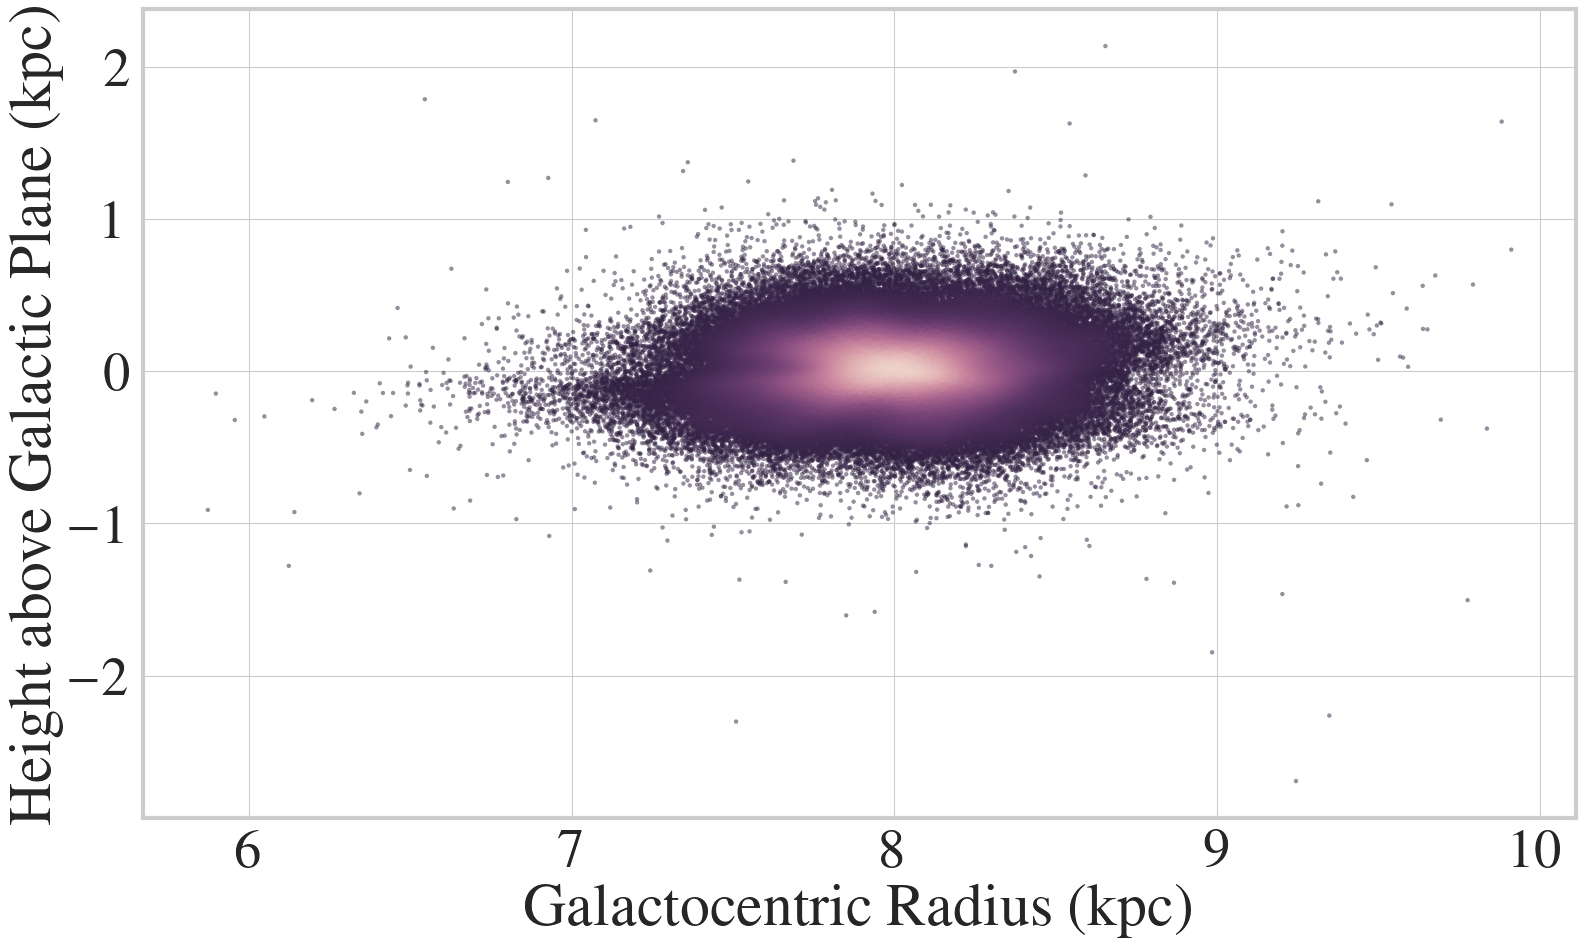

In [ ]:
kernel = gaussian_kde(data[["R", "Z"]].sample(n=10000).T)(data[["R", "Z"]][::10].T)
coordinate_scatterplot = sns.scatterplot(
    data=data[::10].assign(
        Population=data["Population"].replace(
            "Thick Disk Candidate",
            "Thick Disk C.",
        )
    ),
    x="R",
    y="Z",
    c=kernel,
    cmap=get_palette(as_cmap=True, reverse=True),
    s=10,
    alpha=0.5,
    linewidth=0,
    rasterized=True,
)

coordinate_scatterplot.set_xlabel("Galactocentric Radius (kpc)")
coordinate_scatterplot.set_ylabel("Height above Galactic Plane (kpc)")

FigureProcessor(coordinate_scatterplot).save(
    "coordinate_scatterplot.pdf",
    figure_directory=figure_directory,
    save=save,
)

## TOOMRE DIAGRAM

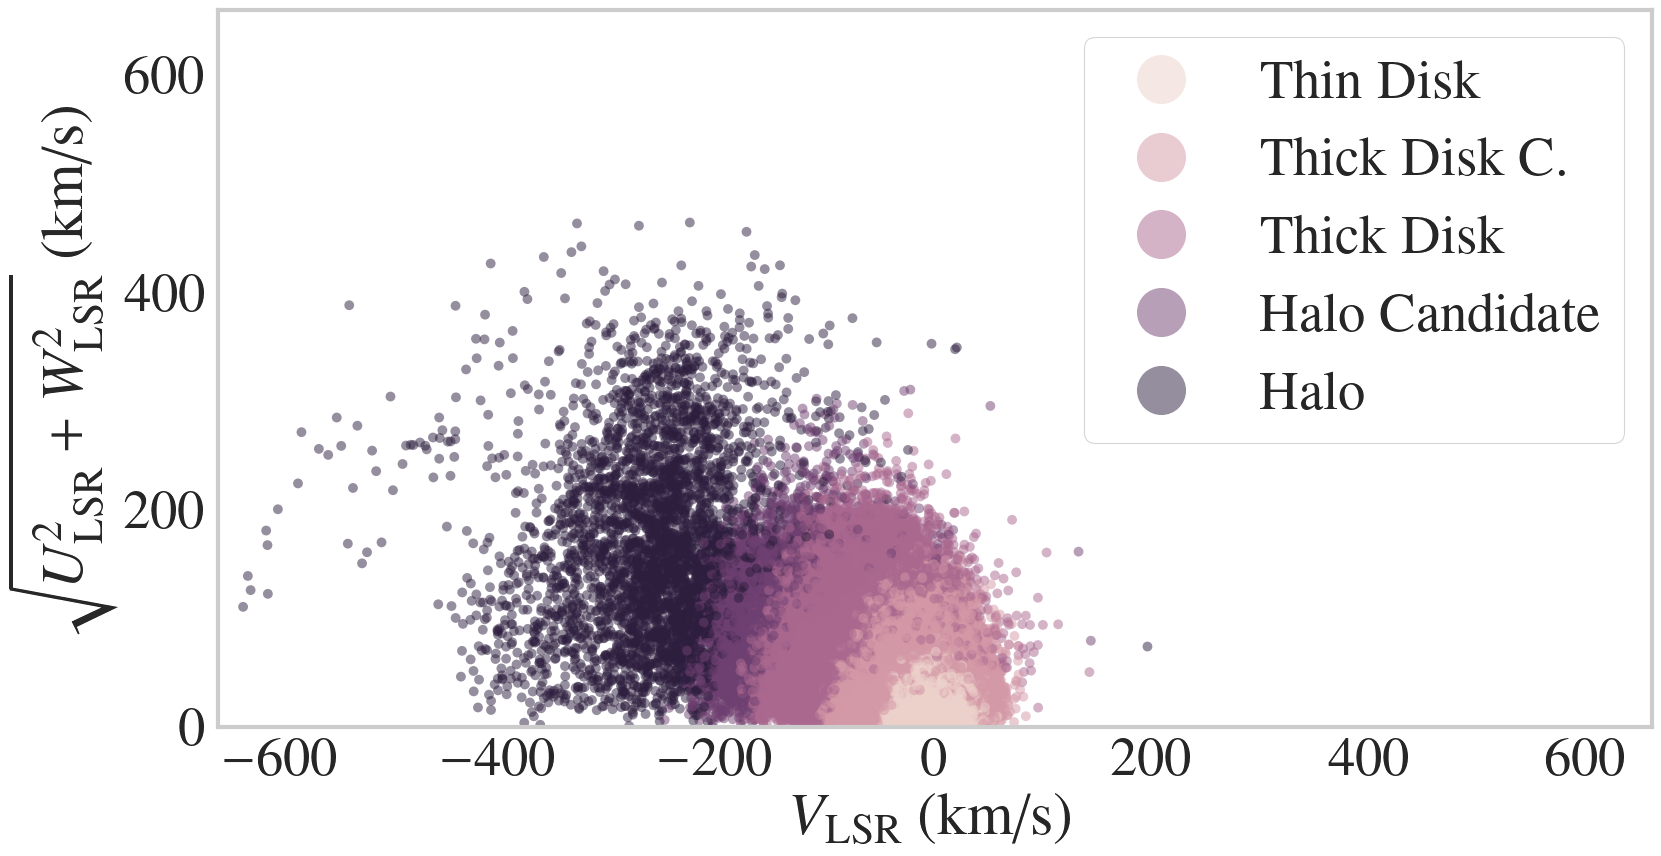

In [ ]:
toomre_scatterplot = sns.scatterplot(
    data=data.assign(
        Population=data["Population"].replace(
            "Thick Disk Candidate",
            "Thick Disk C.",
        )
    ),
    x="V",
    y="UW",
    hue="Population",
    hue_order=["Thin Disk", "Thick Disk C.", "Thick Disk", "Halo Candidate", "Halo"],
    palette=get_palette(n_colors=5),
    alpha=0.5,
    linewidth=0,
    rasterized=True,
    s=50,
)
toomre_scatterplot.set_xlim(-660, 660)
toomre_scatterplot.set_ylim(0, 660)

# for radius in (100, 200, 300):
#     circle = Circle(
#         (0, 0),
#         radius,
#         color="grey",
#         linestyle="-.",
#         linewidth=3,
#         fill=False,
#     )
#     toomre_scatterplot.add_patch(circle)
toomre_scatterplot.set_aspect("equal")

toomre_scatterplot.legend(markerscale=5)
toomre_scatterplot.set_xlabel(r"$V_\mathrm{LSR}$ (km/s)")
toomre_scatterplot.set_ylabel(r"$\sqrt{U_\mathrm{LSR}^2 + W_\mathrm{LSR}^2}$ (km/s)")

FigureProcessor(toomre_scatterplot).save(
    "toomre_scatterplot.pdf",
    figure_directory=figure_directory,
    save=save,
)

## METALLICITY

In [ ]:
print(
    f"Fraction of stars with high resolution spectra [Fe/H] estimates: {data['[Fe/H]_high_res'].count() / len(data):.3f}"
)

Fraction of stars with high resolution spectra [Fe/H] estimates: 0.047


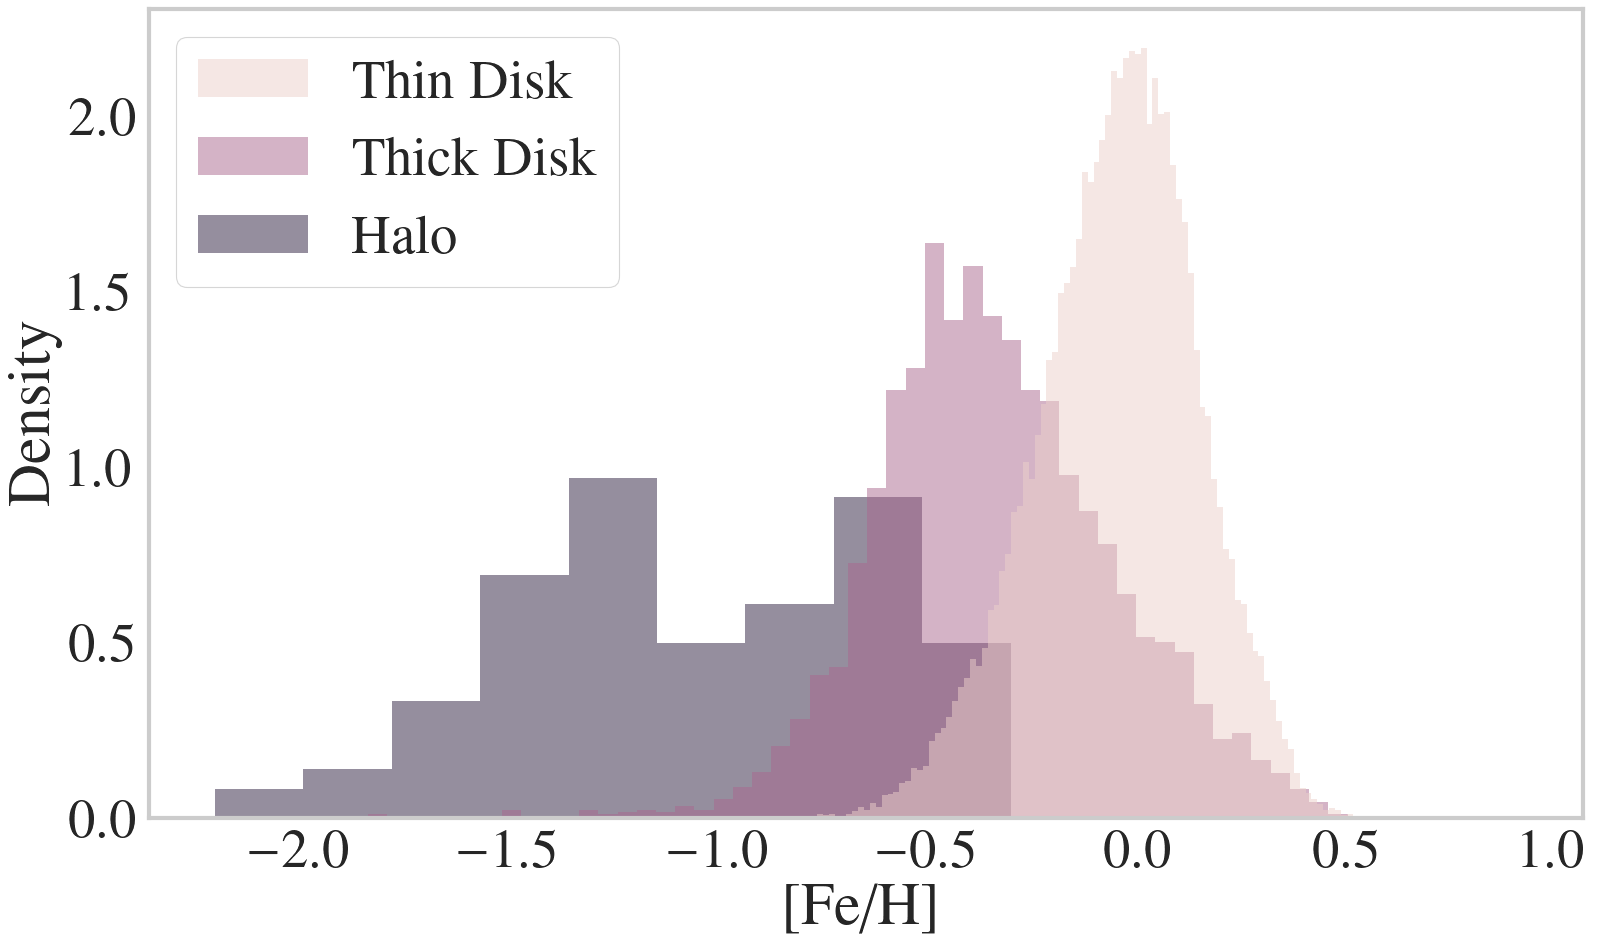

In [ ]:
metallicity_plot = sns.histplot(
    data=data,
    x="[Fe/H]_high_res",
    hue="Population",
    hue_order=["Thin Disk", "Thick Disk", "Halo"],
    stat="density",
    common_bins=False,
    common_norm=False,
    linewidth=0,
    palette=get_palette(n_colors=3),
    legend=True,
    edgecolor="black",
)
metallicity_plot.get_legend().set_title("")
metallicity_plot.set_xlabel("[Fe/H]")

FigureProcessor(metallicity_plot).save(
    "metallicity_hist.pdf",
    figure_directory=figure_directory,
    save=save,
)

## METALLICITY - ALPHA ABUNDANCE

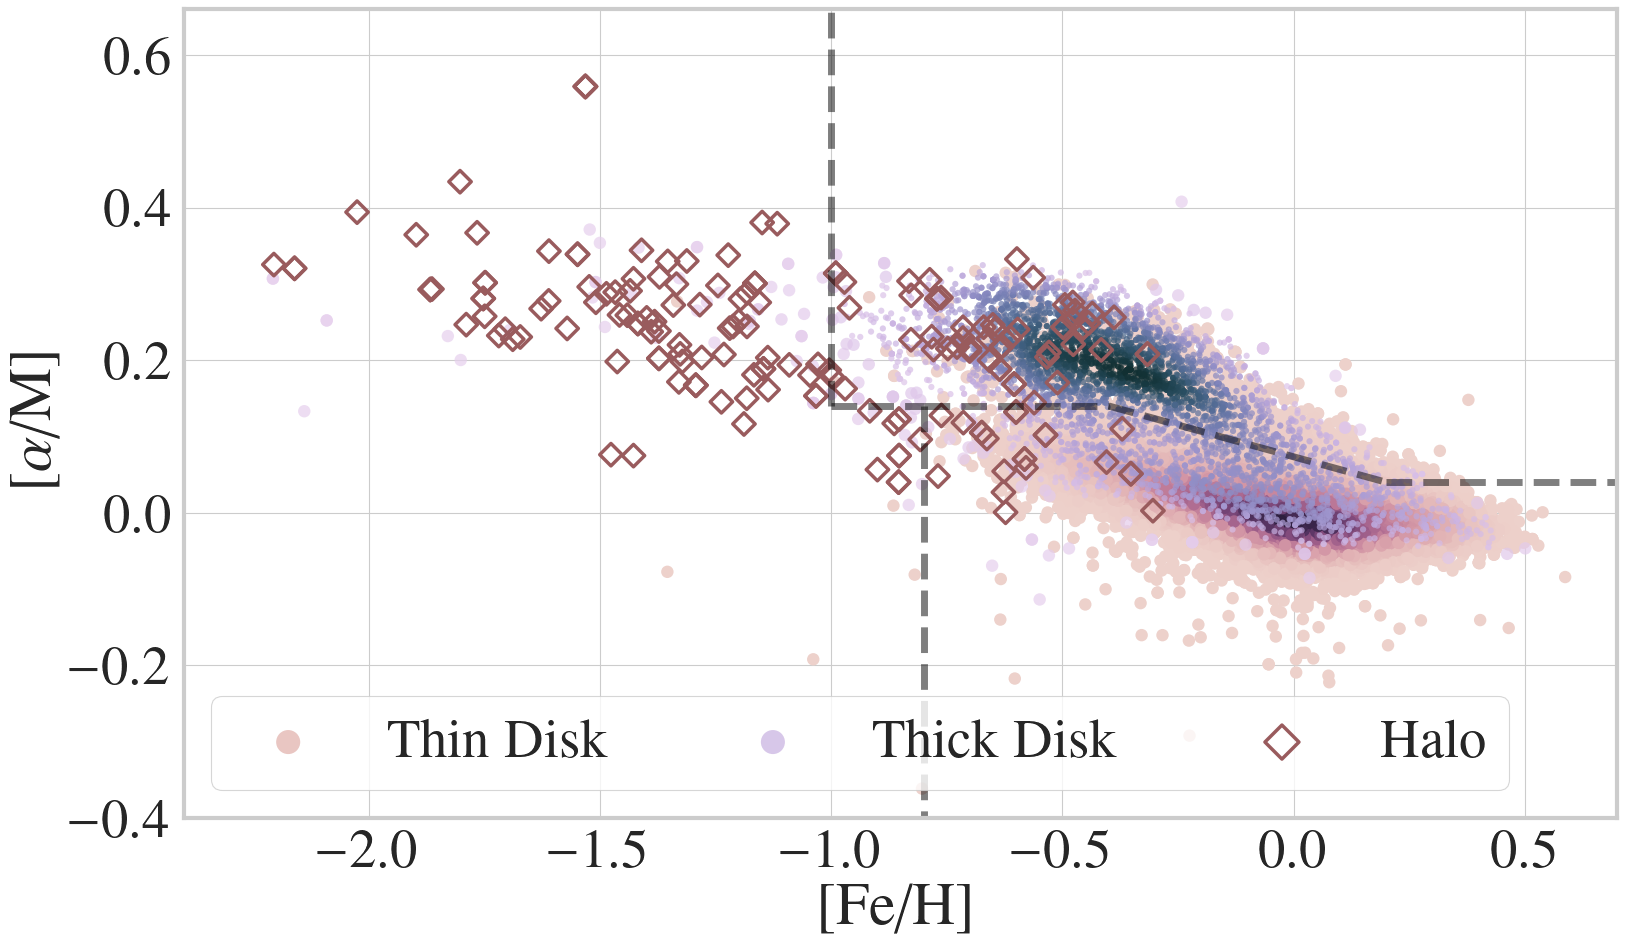

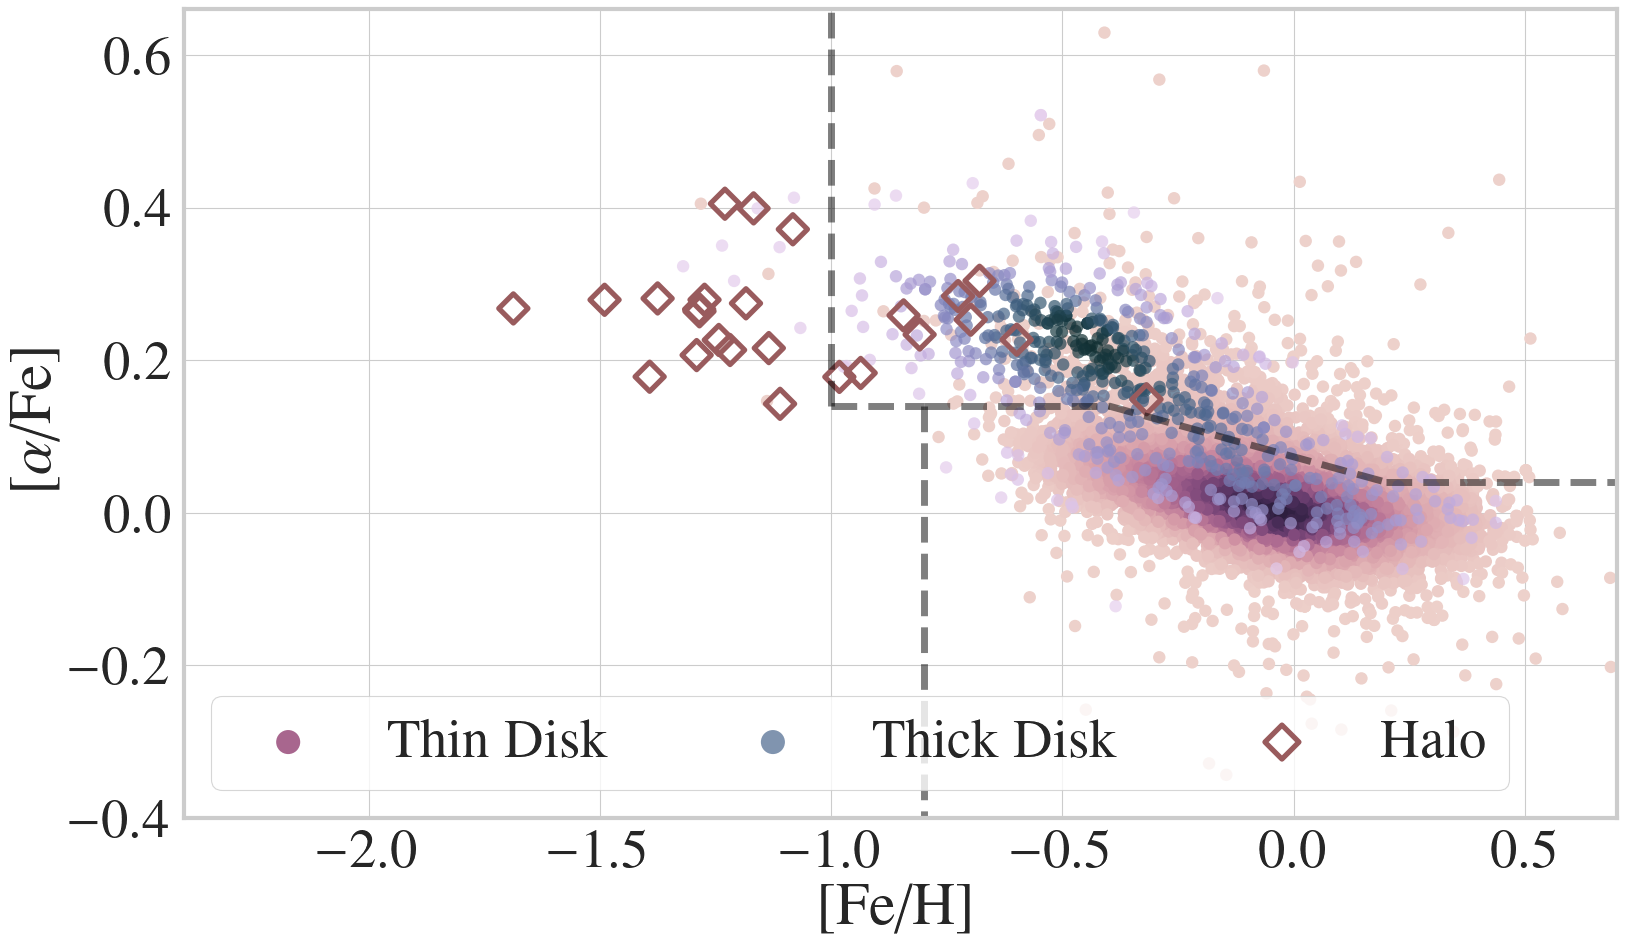

In [27]:
scaler = 0
for dataset, column in {
    "_apogee": "[alpha/M]_apogee",
    "_galah": "[alpha/Fe]_galah",
}.items():
    metallicity_alpha_plot, ax = plt.subplots()
    for i, component in enumerate(["Thin Disk", "Thick Disk"]):

        fit_data = data[data["Population"] == component]
        fit_data = fit_data[[f"[Fe/H]{dataset}", column]].dropna()
        if len(fit_data) == 0:
            continue
        color_kernel = gaussian_kde(fit_data.T)(fit_data.T)

        if dataset == "_galah":
            size = 80
        else:
            if component == "Thin Disk":
                size = 80
            else:
                size_kernel = color_kernel.copy()
                size_kernel[size_kernel < np.percentile(size_kernel, 3)] = (
                    5 * size_kernel.max()
                )
                scatter_range = np.array([20, 80])
                size = MinMaxScaler(feature_range=tuple(scatter_range)).fit_transform(  # type: ignore
                    size_kernel.reshape(-1, 1) ** 4
                )

        ax = sns.scatterplot(
            data=fit_data,
            x=f"[Fe/H]{dataset}",
            y=column,
            c=color_kernel,
            cmap=get_palette(as_cmap=True, start=2.3 * i),
            s=size,
            linewidth=0,
            alpha=1 - 0.3 * i,
            rasterized=True,
            label=component,
            ax=ax,
        )

    sns.scatterplot(
        data=data[data["Population"] == "Halo"],
        x=f"[Fe/H]{dataset}",
        y=column,
        s=130 * (1 + 0.7 * scaler),
        marker="D",
        edgecolor=get_palette(start=0.4)[-3],  # type: ignore
        facecolor="none",
        linewidth=2.5 * (1 + 0.5 * scaler),
        rasterized=True,
        label="Halo",
        ax=ax,
    )

    scaler += 1

    # add chemical classification lines
    c = 0.14
    lines = (
        [[-1, -1], [c, 1]],
        [[-1, -0.8], [c, c]],
        [[-0.8, -0.4], [c, c]],
        [[-0.4, 0.2], [c, c - 0.1]],
        [[0.2, 2], [c - 0.1, c - 0.1]],
        [[-0.8, -0.8], [c, -2]],
    )
    for line in lines:
        ax.plot(
            line[0],
            line[1],
            color="black",
            linestyle="--",
            linewidth=5,
            alpha=0.5,
        )

    # check if anything was plotted before processing and saving
    if len(ax.lines) > 0 or len(ax.collections) > 0:
        adjust_legend(ax, ncols=3, loc="lower left", common_markersize=300)
        ax.set_xlabel("[Fe/H]")
        ax.set_ylabel(column.replace("alpha", r"$\alpha$").replace(dataset, ""))
        ax.set_xlim(-2.4, 0.7)
        ax.set_ylim(-0.4, 0.66)

        FigureProcessor(metallicity_alpha_plot).save(
            f"metallicity_alpha{dataset}.pdf",
            figure_directory=figure_directory,
            save=save,
        )
        plt.show()
    else:
        plt.close()

## METALLICITY TABLES

In [ ]:
data.groupby("Population").agg(
    {
        "[Fe/H]_apogee": ["median"],
        "[alpha/M]_apogee": ["median"],
        "[Fe/H]_galah": ["median"],
        "[alpha/Fe]_galah": ["median"],
    }
).round(2)

,[Fe/H]_apogee,[alpha/M]_apogee,[Fe/H]_galah,[alpha/Fe]_galah
,median,median,median,median
Population,,,,
Halo,-1.05,0.24,-1.17,0.26
Halo Candidate,-0.65,0.24,-0.77,0.26
Thick Disk,-0.36,0.17,-0.38,0.17
Thick Disk Candidate,-0.08,0.03,-0.10,0.03
Thin Disk,-0.03,0.00,-0.06,0.02


## CONTAMINATION ANALYSIS

In [28]:
data = classify_by_chemistry(
    data,
    metallicity_column="[Fe/H]_high_res",
    alpha_column="[alpha/Fe]_high_res",
    c=0.14,
)

# get subset of data that has values in Population column and Population by Chemistry column
data_classified = data.dropna(subset=["Population", "Population by Chemistry"])
# only keep stars that have classification of Thin Disk, Thick Disk, or Halo
data_classified = data_classified[
    data_classified["Population"].isin(["Thin Disk", "Thick Disk", "Halo"])
]

In [29]:
# create confusion matrix
cm = pd.DataFrame(
    confusion_matrix(
        data_classified["Population by Chemistry"],
        data_classified["Population"],
        labels=data_classified["Population"].unique(),
        normalize="pred",
    ),
    index=data_classified["Population"].unique(),
    columns=data_classified["Population"].unique(),
)

# create classification report
cr = classification_report(
    data_classified["Population by Chemistry"],
    data_classified["Population"],
    labels=data_classified["Population"].unique(),
)
print(cr)

              precision    recall  f1-score   support

   Thin Disk       0.96      0.97      0.97     54380
  Thick Disk       0.68      0.59      0.63      5515
        Halo       0.57      0.62      0.60       188

    accuracy                           0.94     60083
   macro avg       0.74      0.73      0.73     60083
weighted avg       0.93      0.94      0.93     60083



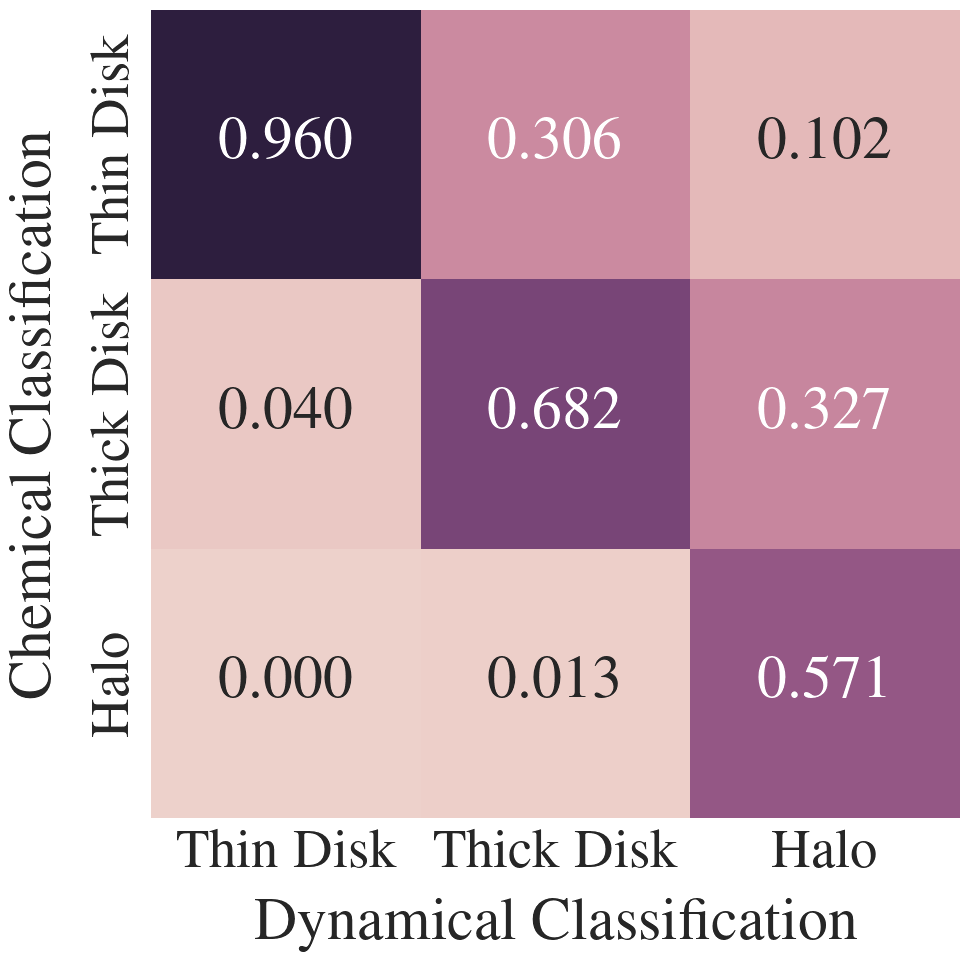

In [33]:
cm = pd.DataFrame(
    confusion_matrix(
        data_classified["Population by Chemistry"],
        data_classified["Population"],
        labels=data_classified["Population"].unique(),
        normalize="pred",
    ),
    index=data_classified["Population"].unique(),
    columns=data_classified["Population"].unique(),
)


confusion_matrix_plot = sns.heatmap(
    data=cm,
    annot=True,
    fmt=".3f",
    cmap=get_palette(as_cmap=True),
    cbar=False,
)
confusion_matrix_plot.set_xlabel("Dynamical Classification", labelpad=15)
confusion_matrix_plot.set_ylabel("Chemical Classification", labelpad=20)
confusion_matrix_plot.set_aspect("equal")

FigureProcessor(confusion_matrix_plot).save(
    "confusion_matrix.pdf",
    figure_directory=figure_directory,
    save=save,
)